![image](https://github.com/eWaterCycle/ewatercycle/raw/main/docs/examples/logo.png)

# Case study 0: Hello worlds. Run two models on the same forcing data and compare output (discharge)
This notebooks demonstrates how to use models in eWaterCycle by showing how to run two different models for the same region (Merrimack) and on the same forcing data (ERA5: 1990).

The models used in this notebook are:

- WFlow (details)
- LISFLood (details)

## Import statements
We'll be using the following modules

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import logging
logger = logging.getLogger('grpc4bmi.bmi_grpc_client')
logger.setLevel(logging.WARNING)

import pandas as pd
from cartopy.io import shapereader

import ewatercycle.forcing
import ewatercycle.models
import ewatercycle.analysis
import ewatercycle.observation.grdc

## eWaterCycle system setup
This notebook was run on cartesius.surfsara.nl as it has a big subset of ERA5 data files, GRDC data and can run models in Singularity containers. 
More information about data, configuration and installation instructions can be found in the [System setup](https://ewatercycle.readthedocs.io/en/latest/system_setup.html) in the eWaterCycle documentation.

## Observation

In [2]:
# Get grdc observations at 4147380 station related to Merrimack
df, metadata = ewatercycle.observation.grdc.get_grdc_data(
    station_id="4147380",
    start_time="1990-01-01T00:00:00Z",
    end_time="1990-12-31T00:00:00Z",
)

# Get lat/lon of the station
station_lat = [metadata["grdc_latitude_in_arc_degree"]]
station_lon = [metadata["grdc_longitude_in_arc_degree"]]

# Convert it to dataframe and rename it to GRDC
observations = df.rename(columns={"streamflow": "GRDC"})
observations

GRDC station 4147380 is selected. The river name is: MERRIMACK RIVER.The coordinates are: (42.6459, -71.2984).The catchment area in km2 is: 12004.7. There are 0 missing values during 1990-01-01T00:00:00Z_1990-12-31T00:00:00Z at this station. See the metadata for more information.


,GRDC
time,
1990-01-01,119.214
1990-01-02,136.204
1990-01-03,131.107
1990-01-04,133.655
1990-01-05,139.035
...,...
1990-12-27,668.276
1990-12-28,512.534
1990-12-29,419.089


## Wflow

### Load forcing data

In [3]:
forcing = ewatercycle.forcing.load_foreign(
    directory = "/projects/0/wtrcycle/comparison/forcing/wflow",
    target_model = "wflow",
    start_time = "1990-01-01T12:00:00Z",
    end_time = "2001-12-31T12:00:00Z",
    forcing_info = dict(
        # Additional information about the external forcing data needed for the model configuration
        netcdfinput = "wflow_ERA5_Merrimack_1990_2001.nc",
        Precipitation = "/pr",
        EvapoTranspiration = "/pet",
        Temperature = "/tas"
    )
)
print(forcing)

Forcing data for Wflow
----------------------
Directory: /lustre1/0/wtrcycle/comparison/forcing/wflow
Start time: 1990-01-01T12:00:00Z
End time: 2001-12-31T12:00:00Z
Shapefile: None
Additional information for model config:
  - netcdfinput: wflow_ERA5_Merrimack_1990_2001.nc
  - Precipitation: /pr
  - Temperature: /tas
  - EvapoTranspiration: /pet
  - Inflow: None


### Load parameterset

In [4]:
parameterset = ewatercycle.parameter_sets.ParameterSet(
    name='wflow_calibrated_parameterset_merrimack',
    directory='/projects/0/wtrcycle/comparison/wflow_parameterset/calibrated_parameterset/merrimack/',
    config='/projects/0/wtrcycle/comparison/wflow_parameterset/calibrated_parameterset/merrimack/wflow_sbm_era5_warmup.ini',
    target_model='wflow'
)
print(parameterset)

Parameter set
-------------
name=wflow_calibrated_parameterset_merrimack
directory=/lustre1/0/wtrcycle/comparison/wflow_parameterset/calibrated_parameterset/merrimack
config=/lustre1/0/wtrcycle/comparison/wflow_parameterset/calibrated_parameterset/merrimack/wflow_sbm_era5_warmup.ini
doi=N/A
target_model=wflow
supported_model_versions=set()


### Set up the model

In [5]:
ewatercycle.models.Wflow.available_versions

('2020.1.1',)

In [6]:
model = ewatercycle.models.Wflow(version='2020.1.1', parameter_set=parameterset, forcing=forcing)

Model version 2020.1.1 is not explicitly listed in the supported model versions of this parameter set. This can lead to compatibility issues.
Config file from parameter set is missing API section, adding section
Config file from parameter set is missing RiverRunoff option in API section, added it with value '2, m/s option'


Forcing time range is 1990-2001, but we want to run the model for the year 1990, so set `end_time` in setup() function:

In [7]:
cfg_file, cfg_dir = model.setup(end_time='1990-12-31T00:00:00Z')
print(cfg_file)
print(cfg_dir)

Running docker://ewatercycle/wflow-grpc4bmi:2020.1.1 singularity container on port 36071


INFO:    Using cached SIF image


/scratch/shared/ewatercycle/case0/wflow_20210716_082100/wflow_ewatercycle.ini
/scratch/shared/ewatercycle/case0/wflow_20210716_082100


In [8]:
# Initialize
model.initialize(cfg_file)

2021-07-16 10:21:26,130 - wflow_ewatercycle.ini - pcrut - DEBUG - File logging to /scratch/shared/ewatercycle/case0/wflow_20210716_082100/run_default/wflow.log
2021-07-16 10:21:26,131 - wflow_ewatercycle.ini - wf_DynamicFramework - INFO - wflow_ewatercycle.ini 2020.1.2.dev8+gfdb404c5 Case: /scratch/shared/ewatercycle/case0/wflow_20210716_082100 Runid: run_default
2021-07-16 10:21:26,131 - wflow_ewatercycle.ini - wf_DynamicFramework - INFO - Initialise framework version: 2020.1.2.dev8+gfdb404c5
2021-07-16 10:21:26,132 - wflow_ewatercycle.ini - wf_DynamicFramework - WARNING - Ini file made for wflow_sbm but found wflow.wflow_sbm in code.
2021-07-16 10:21:26,133 - wflow_ewatercycle.ini - wf_DynamicFramework - DEBUG - Found following input variables to get from netcdf file: ['pr', 'pet', 'tas', 'IF', 'pr', 'tas', 'pet', 'IF']
2021-07-16 10:21:26,145 - wflow_ewatercycle.ini - wf_netcdfio - INFO - Reading input from netCDF file: /scratch/shared/ewatercycle/case0/wflow_20210716_082100/wflow_E

In [9]:
# Get metadata
model.output_var_names

('RiverRunoff',)

### Run the model

We store discharge and time values. For time, only date part is kept using the function `date()`. So, we can create a dataframe joining the data on date later for the hydrograph. Wflow has steps at noon, while GRDC and lisflood uses midnight.

In [10]:
discharge = []
time_range = []
model_end_time = model.end_time
while model.time < model_end_time:
    model.update()
    # Get Discharge at one location
    discharge_at_pixel = model.get_value_at_coords('RiverRunoff', lon=station_lon, lat=station_lat)[0]
    discharge.append(discharge_at_pixel)
    time_range.append(model.time_as_datetime.date())

/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
2021-07-16 10:22:00,152 - wflow_ewatercycle.ini - wf_DynamicFramework - INFO - saving maps
2021-07-16 10:22:00,155 - wflow_ewatercycle.ini - wf_netcdfio - DEBUG - Creating variable run in netcdf file. Format: NETCDF4
2021-07-16 10:22:00,157 - wflow_ewatercycle.ini - wf_netcdfio - DEBUG - Creating variable actevap in netcdf file. Format: NETCDF4
2021-07-16 10:22:00,159 - wflow_ewatercycle.ini - wf_netcdfio - DEBUG - Creating variable vwc_0_ in netcdf file. Format: NETCDF4
2021-07-16 10:22:00,161 - wflow_ewatercycle.ini - wf_netcdfio - DEBUG - Creating variable vwc_1_ in netcdf file. Format: NETCDF4
2021-07-16 10:22:00,162 - wflow_ewatercycle.ini - wf_netcdfio - DEBUG - Creating variable vwc_2_ in netcdf file. Format: NETCDF4
2021-07-16 10:22:00,165 - wflow_ewatercycle.ini - wf_netcdfio - DEBUG - Creating variable 

In [11]:
# Stop the model
model.finalize()

2021-07-16 10:26:01,499 - wflow_ewatercycle.ini - wflow_sbm - INFO - Saving initial conditions...
2021-07-16 10:26:01,559 - wflow_ewatercycle.ini - wf_DynamicFramework - INFO - Saving summary maps to disk...


In [12]:
# Concatenate timeseries
wflow = pd.DataFrame({'wflow': discharge}, index=pd.to_datetime(time_range))
wflow

,wflow
1990-01-01,0.174929
1990-01-02,0.598014
1990-01-03,0.935433
1990-01-04,1.107896
1990-01-05,2.925184
...,...
1990-12-27,590.957458
1990-12-28,512.297424
1990-12-29,451.403503
1990-12-30,447.998962


## Lisflood

### Load forcing data

In [13]:
forcing = ewatercycle.forcing.load_foreign(target_model='lisflood',
                                           directory='/scratch/shared/ewatercycle/case0',
                                           start_time='1990-01-01T12:00:00Z',
                                           end_time='1990-12-31T12:00:00Z',
                                           forcing_info={
                                               'PrefixPrecipitation': 'lisflood_ERA5_pr_1990_1990.nc',
                                               'PrefixTavg': 'lisflood_ERA5_tas_1990_1990.nc',
                                               'PrefixE0': 'lisflood_ERA5_e0_1990_1990.nc',
                                               'PrefixES0': 'lisflood_ERA5_es0_1990_1990.nc',
                                               'PrefixET0': 'lisflood_ERA5_et0_1990_1990.nc',
                                           }
                                          )
print(forcing)

eWaterCycle forcing
-------------------
start_time=1990-01-01T12:00:00Z
end_time=1990-12-31T12:00:00Z
directory=/scratch/shared/ewatercycle/case0
shape=None
PrefixPrecipitation=lisflood_ERA5_pr_1990_1990.nc
PrefixTavg=lisflood_ERA5_tas_1990_1990.nc
PrefixE0=lisflood_ERA5_e0_1990_1990.nc
PrefixES0=lisflood_ERA5_es0_1990_1990.nc
PrefixET0=lisflood_ERA5_et0_1990_1990.nc


### Load parameter set

In [14]:
parameterset = ewatercycle.parameter_sets.ParameterSet(
    name='Lisflood01degree_masked',
    directory='/projects/0/wtrcycle/comparison/lisflood_input/Lisflood01degree_masked',
    config='/projects/0/wtrcycle/comparison/lisflood_input/settings_templates/settings_lisflood.xml',
    target_model='lisflood'
)
print(parameterset)

Parameter set
-------------
name=Lisflood01degree_masked
directory=/lustre1/0/wtrcycle/comparison/lisflood_input/Lisflood01degree_masked
config=/lustre1/0/wtrcycle/comparison/lisflood_input/settings_templates/settings_lisflood.xml
doi=N/A
target_model=lisflood
supported_model_versions=set()


### Set up the model

In [15]:
ewatercycle.models.Lisflood.available_versions

('20.10',)

In [35]:
model = ewatercycle.models.Lisflood(version='20.10', parameter_set=parameterset, forcing=forcing)
print(model)

Model version 20.10 is not explicitly listed in the supported model versions of this parameter set. This can lead to compatibility issues.
eWaterCycle Lisflood
-------------------
Version = 20.10
Parameter set = 
  Parameter set
  -------------
  name=Lisflood01degree_masked
  directory=/lustre1/0/wtrcycle/comparison/lisflood_input/Lisflood01degree_masked
  config=/lustre1/0/wtrcycle/comparison/lisflood_input/settings_templates/settings_lisflood.xml
  doi=N/A
  target_model=lisflood
  supported_model_versions=set()
Forcing = 
  eWaterCycle forcing
  -------------------
  start_time=1990-01-01T12:00:00Z
  end_time=1990-12-31T12:00:00Z
  directory=/scratch/shared/ewatercycle/case0
  shape=None
  PrefixPrecipitation=lisflood_ERA5_pr_1990_1990.nc
  PrefixTavg=lisflood_ERA5_tas_1990_1990.nc
  PrefixE0=lisflood_ERA5_e0_1990_1990.nc
  PrefixES0=lisflood_ERA5_es0_1990_1990.nc
  PrefixET0=lisflood_ERA5_et0_1990_1990.nc


In [36]:
model_mask = '/projects/0/wtrcycle/comparison/recipes_auxiliary_datasets/LISFLOOD/model_mask.nc'

config_file, config_dir = model.setup(end_time='1990-12-31T00:00:00Z', MaskMap=model_mask)
print(config_file)
print(config_dir)

Running /scratch/shared/ewatercycle/case0/ewatercycle-lisflood-grpc4bmi_20.10.sif singularity container on port 41553
/scratch/shared/ewatercycle/case0/lisflood_20210716_090111/lisflood_setting.xml
/scratch/shared/ewatercycle/case0/lisflood_20210716_090111


In [37]:
# Initialize
model.initialize(config_file)

# Get metadata
model.output_var_names

('Discharge',)

### Run the model

The model is masked by the Merrimack catchment shapefile. However, GRDC station (-71.2984, 42.6459) is located outside of the catchment boundary. Therefore, the model returns none value at these coordinates. Here, we use the coordinates (-71.35, 42.65) inside the catchment given by lisflood modelers that is close to the GRDC station.

In [38]:
model_lon = [-71.35]
model_lat = [42.65]
discharge = []
time_range = []
model_end_time = model.end_time
while model.time < model_end_time:
    model.update()
    # Get Discharge at one location
    discharge_at_pixel = model.get_value_at_coords('Discharge', lon=model_lon, lat=model_lat)[0]
    discharge.append(discharge_at_pixel)
    time_range.append(model.time_as_datetime.date())

.Simulation started on 2021-07-16 11:01
362    (estimated simulation end: 2021-07-16 11:23)......................................................................................................................................................................................................................................................................................................................................................................

In [39]:
# Stop the model
model.__del__()

In [40]:
lisflood = pd.DataFrame({'lisflood': discharge}, index=pd.to_datetime(time_range))
lisflood

,lisflood
1990-01-03,9.061750
1990-01-04,15.274644
1990-01-05,30.082788
1990-01-06,51.922786
1990-01-07,84.816580
...,...
1990-12-26,269.439962
1990-12-27,318.036922
1990-12-28,398.285179
1990-12-29,491.402610


## Hydrograph

(<Figure size 720x720 with 2 Axes>,
 (<AxesSubplot:title={'center':'Hydrograph'}, ylabel='Discharge (m$^3$ s$^{-1}$)'>,
  <AxesSubplot:>))

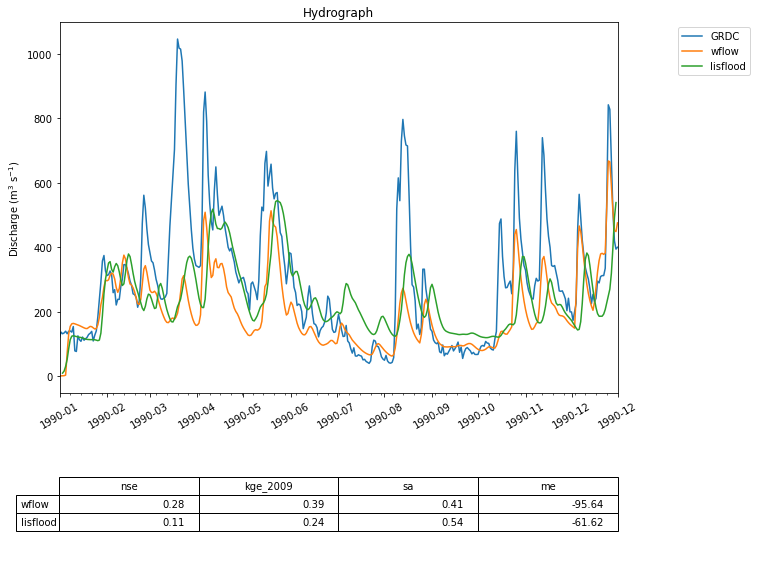

In [41]:
# Combine simulated and observed values to one dataframe according to time axis
hydro_data = pd.concat([wflow, lisflood, observations], axis=1)

# Plot hydrograph and show metrics
ewatercycle.analysis.hydrograph(hydro_data, reference='GRDC')